In [7]:
import numpy as np
import tensorflow as tf
import os
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib


In [8]:
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
print (get_available_gpus())


['/device:GPU:0']


In [9]:

# Đường dẫn đến thư mục train và test
train_dir = r'C:\\Users\\duc18\\@MyData\\@Python\\CatBreedsRefined-7K\\CatBreedsRefined-v2_OutputCutter256'
test_dir = r'C:\\Users\\duc18\\@MyData\\@Python\\CatBreedsRefined-7K\\VL_OutputCutter256'

# Tạo ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Tạo generator từ thư mục train và test
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb'
)


Found 4399 images belonging to 18 classes.
Found 175 images belonging to 18 classes.


In [10]:
# Hiển thị số lượng mẫu trong mỗi lớp cho tập huấn luyện
train_class_counts = np.bincount(train_generator.classes)
for emotion, count in zip(train_generator.class_indices, train_class_counts):
    print(f'Train - {emotion}: {count}')

# Hiển thị số lượng mẫu trong mỗi lớp cho tập kiểm tra
test_class_counts = np.bincount(test_generator.classes)
for emotion, count in zip(test_generator.class_indices, test_class_counts):
    print(f'Test - {emotion}: {count}')

# Hiển thị dạng one-hot của mỗi lớp
for emotion, index in train_generator.class_indices.items():
    one_hot = tf.keras.utils.to_categorical(index, num_classes=len(train_generator.class_indices))
    print(f'{emotion}: {one_hot}')


Train - Abyssinian: 240
Train - American Bobtail: 248
Train - American Curl: 258
Train - American Shorthair: 263
Train - Bengal: 241
Train - Birman: 265
Train - Bombay: 243
Train - British Shorthair: 267
Train - Egyptian Mau: 262
Train - Maine Coon: 274
Train - Norwegian Forest: 267
Train - Persian: 247
Train - Ragdoll: 266
Train - Russian Blue: 268
Train - Scottish Fold: 259
Train - Siamese: 248
Train - Sphynx: 83
Train - Turkish Angora: 200
Test - Abyssinian: 10
Test - American Bobtail: 10
Test - American Curl: 10
Test - American Shorthair: 10
Test - Bengal: 10
Test - Birman: 10
Test - Bombay: 10
Test - British Shorthair: 10
Test - Egyptian Mau: 9
Test - Maine Coon: 10
Test - Norwegian Forest: 11
Test - Persian: 12
Test - Ragdoll: 9
Test - Russian Blue: 10
Test - Scottish Fold: 10
Test - Siamese: 13
Test - Sphynx: 3
Test - Turkish Angora: 8
Abyssinian: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
American Bobtail: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Ame

In [11]:
print (train_generator.class_indices)

{'Abyssinian': 0, 'American Bobtail': 1, 'American Curl': 2, 'American Shorthair': 3, 'Bengal': 4, 'Birman': 5, 'Bombay': 6, 'British Shorthair': 7, 'Egyptian Mau': 8, 'Maine Coon': 9, 'Norwegian Forest': 10, 'Persian': 11, 'Ragdoll': 12, 'Russian Blue': 13, 'Scottish Fold': 14, 'Siamese': 15, 'Sphynx': 16, 'Turkish Angora': 17}


In [12]:
def print_data_shape(generator): # oke, ta đã có kích thước cho mỗi traain hoặc test là 48x48x3
    print(f'Data shape: {generator.image_shape}')

print_data_shape(train_generator)
print_data_shape(test_generator)


Data shape: (256, 256, 3)
Data shape: (256, 256, 3)


In [13]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from keras.regularizers import l2


In [14]:
input_shape=train_generator.image_shape
print (input_shape)

(256, 256, 3)


In [15]:
# Initialize a sequential model
model = Sequential()

# Set the weight decay value for L2 regularization
weight_decay = 0.0001

# Add the first convolutional layer with 32 filters of size 3x3
model.add(Conv2D(input_shape=input_shape, filters=16, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
                #  input_shape=train_generator.image_shape))
# Add batch normalization layer
model.add(BatchNormalization())

# Add the second convolutional layer similar to the first
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the first max pooling layer with pool size of 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add dropout layer with 0.2 dropout rate
model.add(Dropout(rate=0.2))

# Add the third and fourth convolutional layers with 64 filters
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the second max pooling layer and increase dropout rate to 0.3
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.3))

# Add the fifth and sixth convolutional layers with 128 filters
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the third max pooling layer and increase dropout rate to 0.4
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.4))

# Add the seventh and eighth convolutional layers with 256 filters
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the fourth max pooling layer and increase dropout rate to 0.5
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))

# Flatten the tensor output from the previous layer
model.add(Flatten())

# Add a fully connected layer with softmax activation function for outputting class probabilities
model.add(Dense(18, activation='softmax'))

In [16]:
batch_size = 16
epochs = 300
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)
with (tf.device(get_available_gpus()[0])): # 1070ti 
    history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=test_generator,
                    callbacks=[reduce_lr, early_stopping],
                    verbose=2)


Epoch 1/300
275/275 - 33s - loss: 12.0153 - accuracy: 0.1337 - val_loss: 9.4695 - val_accuracy: 0.0743 - lr: 5.0000e-04 - 33s/epoch - 119ms/step
Epoch 2/300
275/275 - 25s - loss: 11.4535 - accuracy: 0.1987 - val_loss: 10.6100 - val_accuracy: 0.2171 - lr: 5.0000e-04 - 25s/epoch - 90ms/step
Epoch 3/300
275/275 - 25s - loss: 10.2439 - accuracy: 0.2162 - val_loss: 27.4313 - val_accuracy: 0.1257 - lr: 5.0000e-04 - 25s/epoch - 90ms/step
Epoch 4/300
275/275 - 25s - loss: 9.1642 - accuracy: 0.2630 - val_loss: 12.3487 - val_accuracy: 0.2571 - lr: 5.0000e-04 - 25s/epoch - 91ms/step
Epoch 5/300
275/275 - 25s - loss: 7.8009 - accuracy: 0.3046 - val_loss: 15.6806 - val_accuracy: 0.2400 - lr: 5.0000e-04 - 25s/epoch - 90ms/step
Epoch 6/300
275/275 - 25s - loss: 6.4472 - accuracy: 0.3564 - val_loss: 12.6399 - val_accuracy: 0.2629 - lr: 5.0000e-04 - 25s/epoch - 90ms/step
Epoch 7/300
275/275 - 25s - loss: 5.6375 - accuracy: 0.4087 - val_loss: 12.6221 - val_accuracy: 0.2400 - lr: 5.0000e-04 - 25s/epoch -

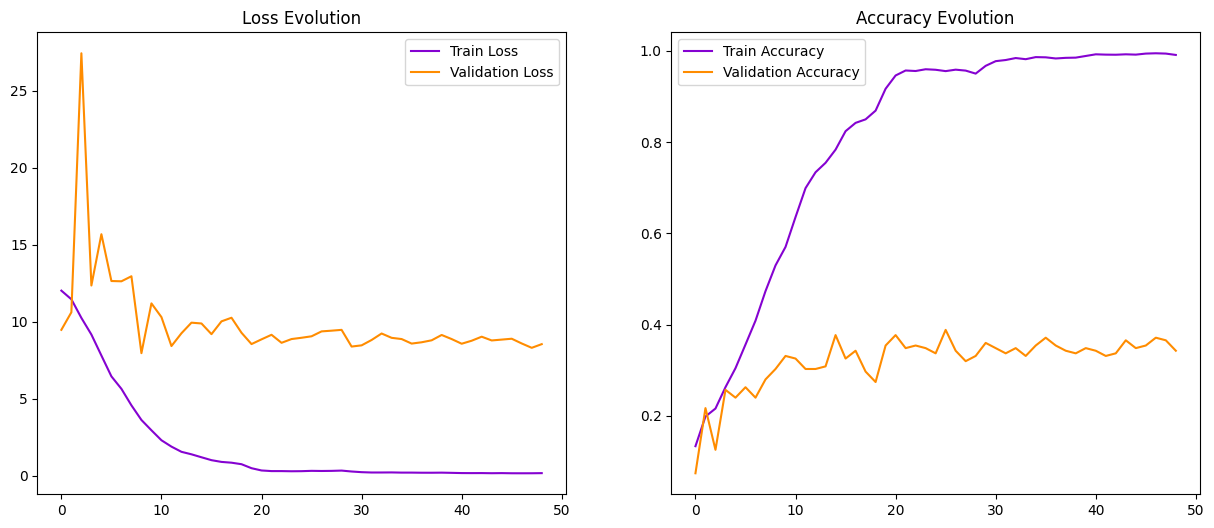

In [17]:

import matplotlib.pyplot as plt
# Plotting the training and validation loss
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()


In [18]:
test_loss, test_acc = model.evaluate(test_generator, verbose=1)

print('\nTest Accuracy:', test_acc)
print('Test Loss:    ', test_loss)

11/11 [==============================] - 1s 37ms/step - loss: 7.9545 - accuracy: 0.3029

Test Accuracy: 0.3028571307659149
Test Loss:     7.954537391662598


In [19]:
model.save("my_model_VGG16.h5")